## Random agents with stepped vault APR

In [1]:
import logging

import numpy as np
from numpy.random._generator import Generator
from scipy import special
import matplotlib.pyplot as plt

from elfpy import DEFAULT_LOG_MAXBYTES
from elfpy.types import MarketActionType, MarketAction, WEI
from elfpy.agent import Agent
from elfpy.markets import Market
from elfpy.utils.config import Config
from elfpy.utils import sim_utils
import elfpy.utils.outputs as output_utils
import elfpy.utils.parse_config as config_utils
import elfpy.utils.post_processing as post_processing
from elfpy.utils.outputs import get_gridspec_subplots

### Setup experiment parameters

In [2]:

log_filename = "../../.logging/random_agent_demo.log" # Output filename for logging
config_file = "../../config/example_config.toml" # Config file to start from (overrides are specified below)

log_level = "WARNING" # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
max_bytes = DEFAULT_LOG_MAXBYTES # Maximum log file output size, in bytes. More than 100 files will cause overwrites.
pricing_model = "Hyperdrive" # can be yieldspace or hyperdrive

num_trading_days = 10#365 # Number of simulated trading days
blocks_per_day = 10#720 # Blocks in a given day (7200 means ~12 sec per block)
target_liquidity = 1e7 # target total liquidity of the initial market, before any trades
target_pool_apr = 0.05 # target pool APR of the initial market after the LP
fee_percent = 0.10 # fee percent collected on trades

num_agents = 5 # int specifying how many agents you want to simulate
agent_budget = 10_000 # max money an agent can spend
trade_chance = 5 / blocks_per_day # on a given block, an agent will trade with probability `trade_chance`

vault_apr_init = 0.01 # Initial vault APR
vault_apr_jump_size = 0.06 # Scale of the vault APR change (vault_apr (+/-)= jump_size)
vault_jumps_per_year = 150#4 # The average number of jumps per year
vault_apr_jump_direction = "up" # The direction of a rate change. Can be 'up', 'down', or 'random'.
vault_apr_lower_bound = 0.0 # minimum allowable vault apr
vault_apr_upper_bound = 0.6 # maximum allowable vault apr

In [3]:
override_dict = {
    "pricing_model_name": pricing_model,
    "num_trading_days": num_trading_days,
    "num_blocks_per_day": blocks_per_day,
    "pricing_model_name": pricing_model,
    "target_liquidity": target_liquidity,
    "target_pool_apr": target_pool_apr,
    "fee_percent": fee_percent,
    "logging_level": log_level,
}
config = config_utils.override_config_variables(config_utils.load_and_parse_config_file(config_file), override_dict)

### Setup random agent

In [4]:
class RandomAgent(Agent):
    """
    Agent that randomly opens or closes longs or shorts
    """

    def __init__(self, rng: Generator, trade_chance: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: Market) -> list[MarketAction]:
        """Implement a random user strategy

        The agent performs one of four possible trades:
            [OPEN_LONG, OPEN_SHORT, CLOSE_LONG, CLOSE_SHORT]
            with the condition that close actions can only be performed after open actions

        The amount opened and closed is random, within constraints given by agent budget & market reserve levels

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        # User can always open a trade, and can close a trade if one is open
        available_actions = [MarketActionType.OPEN_SHORT, MarketActionType.OPEN_LONG]
        has_opened_short = bool(any((short.balance > 0 for short in self.wallet.shorts.values())))
        if has_opened_short:
            available_actions.append(MarketActionType.CLOSE_SHORT)
        has_opened_long = bool(any((long.balance > 0 for long in self.wallet.longs.values())))
        if has_opened_long:
            available_actions.append(MarketActionType.CLOSE_LONG)
        action_type = self.rng.choice(available_actions, size=1) # choose one random trade type
        # trade amount is also randomly chosen
        match action_type:
            case MarketActionType.OPEN_SHORT:
                random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
                max_short = self.get_max_short(market)
                if max_short > WEI: # if max_short is greater than the minimum eth amount
                    trade_amount = np.maximum(WEI, np.minimum(max_short, random_normal)) # WEI <= trade_amount <= max_short
                    action_list = [
                        self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=market.time),
                    ]
                else: # no short is possible
                    action_list = []
            case MarketActionType.OPEN_LONG:
                random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
                max_long = self.get_max_long(market)
                if max_long > WEI: # if max_long is greater than the minimum eth amount
                    trade_amount = np.maximum(WEI, np.minimum(max_long, random_normal))
                    action_list = [
                        self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=market.time),
                    ]
                else:
                    action_list = []
            case MarketActionType.CLOSE_SHORT:
                short_time = self.rng.choice(list(self.wallet.shorts))
                trade_amount = self.wallet.shorts[short_time].balance # close the full trade
                action_list = [
                    self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=short_time),
                ]
            case MarketActionType.CLOSE_LONG:
                long_time = self.rng.choice(list(self.wallet.longs))
                trade_amount = self.wallet.longs[long_time].balance # close the full trade
                action_list = [
                    self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=long_time),
                ]
        return action_list


def get_example_agents(rng: Generator, budget: float, new_agents: int, existing_agents: int = 0) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + new_agents):
        agent = RandomAgent(
            rng=rng,
            trade_chance=trade_chance,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    return agents

### Define vault apr process

In [5]:
def homogeneous_poisson(
    rng: Generator, rate: float, tmax: int, bin_size: int = 1
    ) -> np.ndarray:
    """Generate samples from a homogeneous Poisson distribution

    Attributes
    ----------
    rng: np.random.Generator
        random number generator with preset seed
    rate: float
        number of events per time interval (units of 1/days)
    tmax: float
        total number of days (units of days; sets distribution support)
    bin_size: float
        resolution of the simulation
    """
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    events = (rng.random(nbins) < prob_of_spike).astype(int)
    return events

def event_generator(rng, n_trials, rate, tmax, bin_size):
    """Generate samples from the poisson distribution"""
    for i in range(n_trials):
        yield homogeneous_poisson(rng, rate, tmax, bin_size)

def poisson_prob(k, lam):
    """https://en.wikipedia.org/wiki/Poisson_distribution"""
    return lam**k/special.factorial(k)*np.exp(-lam)

def vault_flip_probs(apr: float, min_apr: float=0.0, max_apr: float=1.0, num: int = 100):
    """
    probability of going up is 1 when apr is min
    probability of going down is 1 when apr is max
    probability is 0.5 either way when apr is half way between max and min
    """
    aprs = np.linspace(min_apr, max_apr, num)
    get_index = lambda value, array : (np.abs(array - value)).argmin()
    apr_index = get_index(apr, aprs) # return whatever value in aprs array that apr is closest to
    up_probs = np.linspace(1, 0, num)
    up_prob = up_probs[apr_index]
    down_prob = 1 - up_prob
    return (down_prob, up_prob)

def poisson_vault_apr(
    config: Config,
    initial_apr: float,
    jump_size: float,
    vault_jumps_per_year: int,
    direction: str,
    lower_bound: float = 0.0,
    upper_bound: float = 1.0,
    num: int = 100
) -> Generator:
    # vault rate changes happen once every vault_jumps_per_year, on average
    num_bins = 365
    bin_size = 1
    rate = vault_jumps_per_year / num_bins
    tmax = num_bins
    do_jump = homogeneous_poisson(config.simulator.rng, rate, tmax, bin_size)
    vault_apr = np.array([initial_apr] * config.simulator.num_trading_days)
    for day in range(config.simulator.num_trading_days):
        if not do_jump[day]:
            continue
        match direction:
            case "up":
                sign = 1
            case "down":
                sign = -1
            case "random":
                sign = config.simulator.rng.choice([-1, 1], size=1).item() # flip a coin
            case "random_weighted":
                probs = vault_flip_probs(vault_apr[day], lower_bound, upper_bound, num)
                sign = config.simulator.rng.choice([-1, 1], p=probs, size=1).item() # flip a coin
            case _:
                raise ValueError(f"Direction must be 'up', 'down', or 'random'; not {direction}")
        step = sign * jump_size
        apr = np.minimum(upper_bound, np.maximum(lower_bound, vault_apr[day] + step))
        vault_apr[day:] = apr
    for apr in vault_apr: # janky way to make this a generator
        yield apr

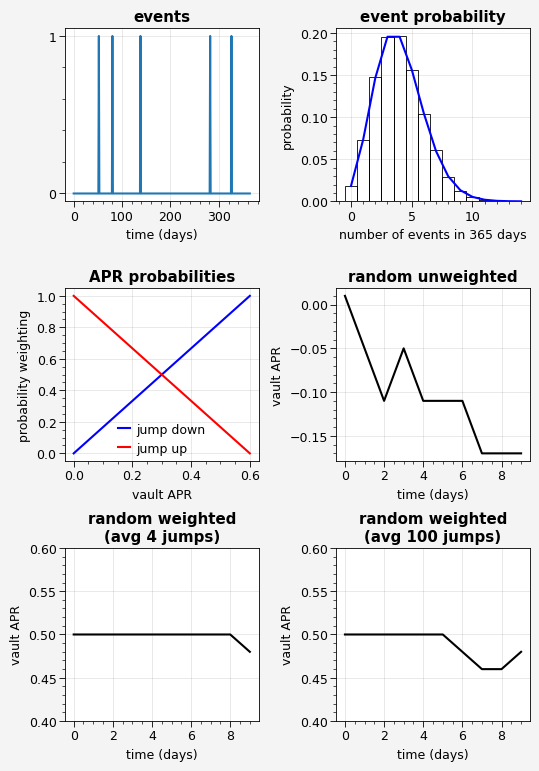

In [6]:
fig, axs, gridspec = get_gridspec_subplots(nrows=3, ncols=2, hspace=0.5, wspace=0.4)

tmp_config = config_utils.load_and_parse_config_file(config_file)
rng = tmp_config.simulator.rng
n_trials = 1
avg_events_per_interval = 4 # 1 event every 3 months = 4 events per year; same as vault_jumps_per_year
num_bins = 365 # days in a year
bin_size = 1
rate = avg_events_per_interval / num_bins
tmax = num_bins
events_poisson = list(event_generator(rng, n_trials, rate, tmax, bin_size))[0]
time = np.arange(len(events_poisson))
axs[0].plot(time, events_poisson)
axs[0].set_title("events")
axs[0].set_xlabel("time (days)")
axs[0].set_yticks([0, 1])

n_trials = 100000
n_events = np.array([np.sum(events) for events in event_generator(rng, n_trials, rate, tmax, bin_size)])
bin_edges =  np.arange(n_events.max() + 1) - 0.5
lam = rate * tmax
k = bin_edges + 0.5
prob = poisson_prob(k, lam)
axs[1].hist(n_events, bin_edges, density=True, fc="none", ec="k")
axs[1].plot(k, prob, c="b")
axs[1].set_title("event probability")
axs[1].set_xlabel(f"number of events in {tmax} days")
axs[1].set_ylabel(f"probability")

num_points = 1000
aprs = np.linspace(vault_apr_lower_bound, vault_apr_upper_bound, num=num_points)
probs = [vault_flip_probs(apr, vault_apr_lower_bound, vault_apr_upper_bound, num=num_points) for apr in aprs]
down_probs = [prob[0] for prob in probs]
up_probs = [prob[1] for prob in probs]
axs[2].plot(aprs, down_probs, c='b', label="jump down")
axs[2].plot(aprs, up_probs, c='r', label="jump up")
axs[2].set_title("APR probabilities")
axs[2].set_xlabel("vault APR")
axs[2].set_ylabel("probability weighting")
axs[2].legend()

vault_apr = list(poisson_vault_apr(
    config=config,
    initial_apr=vault_apr_init,
    jump_size=vault_apr_jump_size,
    vault_jumps_per_year=vault_jumps_per_year,
    direction="random",
    lower_bound=-100,
    upper_bound=100
))
axs[3].plot(np.arange(config.simulator.num_trading_days), vault_apr, c='k')
axs[3].set_xlabel("time (days)")
axs[3].set_ylabel("vault APR")
axs[3].set_title("random unweighted")

lower_bound = 0.4 # use new values to demonstrate how bounds work with random weights
upper_bound = 0.6
vault_apr = list(poisson_vault_apr(
    config=config,
    initial_apr=lower_bound + (upper_bound - lower_bound)/2,
    jump_size=(upper_bound - lower_bound)/10,
    vault_jumps_per_year=4,
    direction="random_weighted",
    lower_bound=lower_bound,
    upper_bound=upper_bound
))
axs[4].plot(np.arange(config.simulator.num_trading_days), vault_apr, c='k')
axs[4].set_xlabel("time (days)")
axs[4].set_ylabel("vault APR")
axs[4].set_title("random weighted\n(avg 4 jumps)")
axs[4].set_ylim([lower_bound, upper_bound])

vault_apr = list(poisson_vault_apr(
    config=config,
    initial_apr=lower_bound + (upper_bound - lower_bound)/2,
    jump_size=(upper_bound - lower_bound)/10,
    vault_jumps_per_year=100,
    direction="random_weighted",
    lower_bound=lower_bound,
    upper_bound=upper_bound
))
axs[5].plot(np.arange(config.simulator.num_trading_days), vault_apr, c='k')
axs[5].set_xlabel("time (days)")
axs[5].set_ylabel("vault APR")
axs[5].set_title("random weighted\n(avg 100 jumps)")
axs[5].set_ylim([lower_bound, upper_bound])


fig_w = 6
fig_h =  fig_w * 3/2
fig.set_size_inches((fig_w, fig_h))

### Setup experiment vault apr using parameters specified above

In [7]:
# override the vault_apr, which is based on some variables set above
override_dict["vault_apr"] = lambda: poisson_vault_apr(
    config=config,
    initial_apr=vault_apr_init,
    jump_size=vault_apr_jump_size,
    vault_jumps_per_year=vault_jumps_per_year,
    direction=vault_apr_jump_direction,
    lower_bound=vault_apr_lower_bound,
    upper_bound=vault_apr_upper_bound,
)
config = config_utils.override_config_variables(config, override_dict)

### Run the simulation

In [8]:
# define root logging parameters
output_utils.setup_logging(
    log_filename=log_filename,
    max_bytes=max_bytes,
    log_level=config_utils.text_to_logging_level(config.simulator.logging_level),
)

# initialize the simulator
random_agents = get_example_agents(rng=config.simulator.rng, budget=agent_budget, new_agents=num_agents, existing_agents=1)
simulator = sim_utils.get_simulator(config, random_agents)

# run the simulation
simulator.run_simulation()

### Plot simulation results

In [9]:
trades = post_processing.compute_derived_variables(simulator)

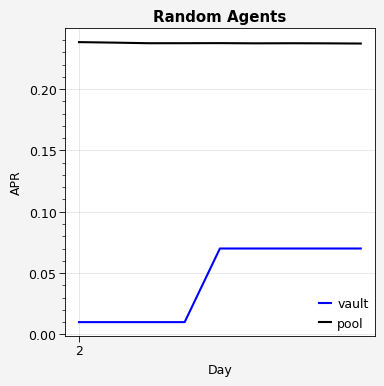

In [10]:
logging.getLogger().setLevel(logging.WARNING)  # events of this level and above will be tracked
exclude_first_day = True
trades_agg = trades.groupby("day").agg(
    {
        "vault_apr": ["mean"],
        "pool_apr": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
xtick_step = 50
start_idx = 1 if exclude_first_day else 0
ax = get_gridspec_subplots()[1][0]
ax = trades_agg.iloc[start_idx:].plot(x="day", y="vault_apr_mean", ax=ax, label="vault", c='blue')
ax = trades_agg.iloc[start_idx:].plot(x="day", y="pool_apr_mean", ax=ax, label="pool", c='black')
ax.set_title("Random Agents")
ax.set_xlabel("Day")
ax.set_ylabel("APR")
ax.legend()
ax.set_xticks([x for x in range(start_idx, simulator.config.simulator.num_trading_days + 1, xtick_step)]);
ax.set_xticklabels([str(x+1) for x in range(start_idx, simulator.config.simulator.num_trading_days + 1, xtick_step)]);

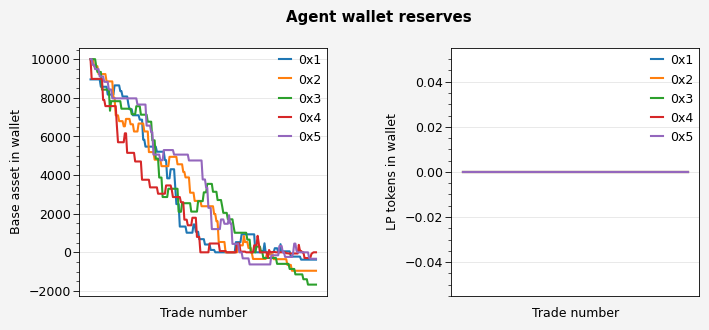

In [11]:
fig = output_utils.plot_wallet_returns(trades, exclude_first_agent=True, exclude_first_trade=True, xtick_step=2000)

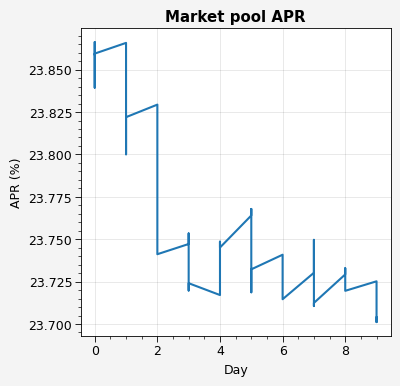

In [12]:
fig = output_utils.plot_pool_apr(trades, exclude_first_trade=True)

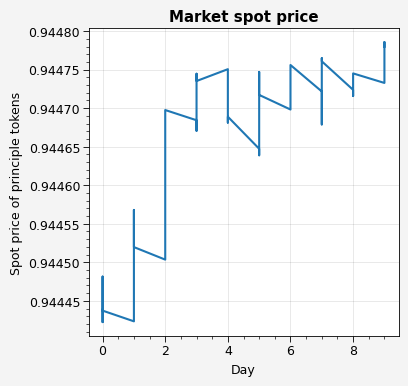

In [13]:
fig = output_utils.plot_market_spot_price(trades, exclude_first_trade=True)

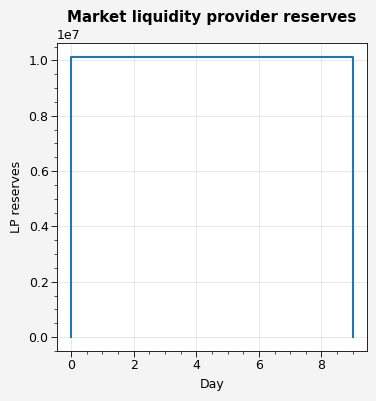

In [14]:
fig = output_utils.plot_market_lp_reserves(trades, exclude_first_trade=True)

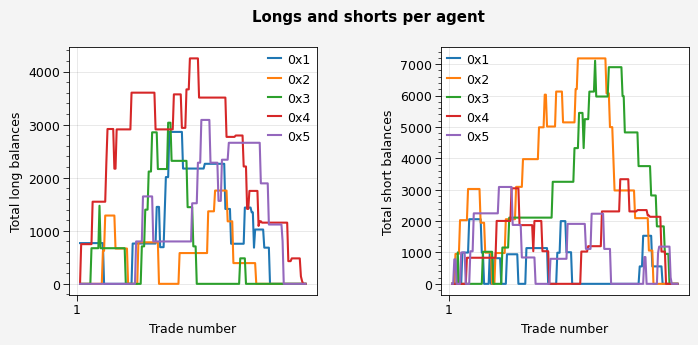

In [15]:
fig = output_utils.plot_longs_and_shorts(trades, exclude_first_trade=True, xtick_step=2000)